# Clustering
This notebook details the pipeline for clustering.

In [1]:
# Useful starting lines
%matplotlib inline
%load_ext autoreload
%autoreload 2

## Load the data 
When loading the chord dataset, we can choose whether to keep sections in major or minor key, or both.

In [2]:
from load_data import load_chord_data_sentences, all_composers

In [3]:
# Optional parameter for load_chord_data: key_mode = 'both'/'major'/'minor'
chord_sentences = load_chord_data_sentences(all_composers, key_mode='major')

In [4]:
# Print chord frequencies
chord_freq = {}
for sentence in chord_sentences:
    for chord in sentence:
        if chord not in chord_freq:
            chord_freq[chord] = 0
        chord_freq[chord] += 1

print(sorted(chord_freq.items(), key=lambda kv: kv[1], reverse=True))

[('I:MAJ', 18650), ('V:MAJ', 16487), ('IV:MAJ', 6041), ('II:MIN', 5794), ('VI:MIN', 3892), ('VII:DIM', 3309), ('II:MAJ', 2224), ('#IV:DIM', 1547), ('III:MIN', 1220), ('VI:MAJ', 1115), ('III:MAJ', 1044), ('#I:DIM', 774), ('#V:DIM', 517), ('bVII:MAJ', 516), ('V:MIN', 510), ('I:MIN', 504), ('III:DIM', 476), ('IV:MIN', 465), ('II:DIM', 382), ('VII:MAJ', 355), ('#II:DIM', 307), ('bVI:MAJ', 294), ('bIII:MAJ', 288), ('I:AUG', 229), ('#IV:MAJ', 211), ('bII:MAJ', 141), ('VII:MIN', 117), ('VI:DIM', 116), ('V:AUG', 84), ('bVII:MIN', 72), ('V:DIM', 64), ('#I:MAJ', 54), ('#II:MAJ', 48), ('#VI:DIM', 46), ('##IV:DIM', 46), ('I:DIM', 44), ('#V:MAJ', 41), ('bVI:AUG', 39), ('bV:MAJ', 33), ('#IV:MIN', 29), ('IV:AUG', 25), ('bIII:MIN', 25), ('IV:DIM', 19), ('#VII:DIM', 18), ('bIV:MAJ', 17), ('bI:MAJ', 14), ('bIII:AUG', 12), ('#VI:MAJ', 11), ('bII:MIN', 10), ('bVII:DIM', 8), ('bVI:MIN', 8), ('bIII:DIM', 8), ('#II:MIN', 8), ('III:AUG', 8), ('II:AUG', 7), ('bI:MIN', 7), ('#I:MIN', 7), ('#V:MIN', 6), ('#III:D

## Apply Word2Vec

In [5]:
from gensim.models import Word2Vec

In [6]:
# Ignore words with a lower frequency frequency than this
min_count = 50
# Size of the embedding space
size = 5
# Neighborhood of the focus word to study
window = 3
# 0 for CBOW, 1 for skip-gram
sg = 1
# Number of iterations (epochs)
iter = 500
#seed
seed = 42
#Workers (controls the speed of the operations)
workers=1



# The first argument has to be a list of lists of words
w2v_model = Word2Vec(chord_sentences, min_count=min_count, workers=workers, size=size, seed=seed, window=window, sg=sg, iter=iter)

In [7]:
w2v_model.wv.vocab.keys()

dict_keys(['I:MAJ', 'V:MAJ', 'IV:MAJ', '#IV:DIM', 'II:MAJ', 'VI:MIN', 'bVII:MAJ', 'VII:DIM', 'III:MAJ', 'VI:MAJ', 'II:MIN', '#I:DIM', 'V:MIN', 'III:DIM', 'II:DIM', 'IV:MIN', '#V:DIM', 'VII:MAJ', 'III:MIN', 'I:MIN', 'VII:MIN', 'bIII:MAJ', 'bVI:MAJ', '#II:DIM', 'VI:DIM', 'I:AUG', 'V:AUG', 'bVII:MIN', 'bII:MAJ', '#IV:MAJ', 'V:DIM', '#I:MAJ'])

## Isolate clusters, reduce dimensionality and visualise
We want to visualise the chord vectors and to find similarities among them.  
We isolate clusters, then we plot the dimensionality-reduced word vectors, highlighting the clusters by colour.

### K-means

In [8]:
from sklearn.cluster import KMeans
from dimred_cluster import cluster_keyed_vec

#### Hyperparameter selection for k-means: n_clusters

In [9]:
from matplotlib import pyplot as plt

2  4  3  5  4  6  5  3  3  4  4  2  3  2  3  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  

Text(0, 0.5, 'K-means loss')

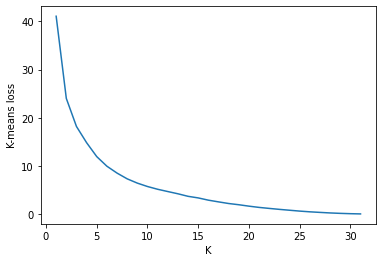

In [10]:
# The possible values of k
ks = range(1, len(w2v_model.wv.vocab.keys()))

inertias = []
for k in ks:
    kmeans = KMeans(n_clusters=k, tol=1e-10, n_init=100)
    wv_clus, clusters = cluster_keyed_vec(w2v_model.wv, kmeans, relabel=False)
    print(kmeans.n_iter_, ' ', end='')
    inertias.append(kmeans.inertia_)

plt.plot(ks, inertias)
plt.xlabel('K')
plt.ylabel('K-means loss')
# Hmmm, not that useful...

### Agglomerative hierachical clustering

In [11]:
from sklearn.cluster import AgglomerativeClustering
from dimred_cluster import cluster_keyed_vec

In [12]:
# The 'affinity' parameter is the metric used. The 'linkage' parameter is the law to define the distance between clusters;
# linkage='complete' means we take the 'max-distance' described in the paper.
agglomerative = AgglomerativeClustering(n_clusters=None, affinity='cosine', distance_threshold=0, linkage='complete')
# 'wv_clus' is a dictionary mapping chords to cluster index. 'clusters' is a list of clusters, each a list of chords.
# 'relabel=True' relabels the cluster in decreasing order of size.
wv_clus, clusters, relabelling = cluster_keyed_vec(w2v_model.wv, agglomerative, relabel=True)

print(wv_clus, '\n')
for label in sorted(clusters.keys()):
    print(label, ':', clusters[label])
print('\n', relabelling, '\n')

{'I:MAJ': 0, 'V:MAJ': 1, 'IV:MAJ': 2, '#IV:DIM': 3, 'II:MAJ': 4, 'VI:MIN': 5, 'bVII:MAJ': 6, 'VII:DIM': 7, 'III:MAJ': 8, 'VI:MAJ': 9, 'II:MIN': 10, '#I:DIM': 11, 'V:MIN': 12, 'III:DIM': 13, 'II:DIM': 14, 'IV:MIN': 15, '#V:DIM': 16, 'VII:MAJ': 17, 'III:MIN': 18, 'I:MIN': 19, 'VII:MIN': 20, 'bIII:MAJ': 21, 'bVI:MAJ': 22, '#II:DIM': 23, 'VI:DIM': 24, 'I:AUG': 25, 'V:AUG': 26, 'bVII:MIN': 27, 'bII:MAJ': 28, '#IV:MAJ': 29, 'V:DIM': 30, '#I:MAJ': 31} 

0 : ['I:MAJ']
1 : ['V:MAJ']
2 : ['IV:MAJ']
3 : ['#IV:DIM']
4 : ['II:MAJ']
5 : ['VI:MIN']
6 : ['bVII:MAJ']
7 : ['VII:DIM']
8 : ['III:MAJ']
9 : ['VI:MAJ']
10 : ['II:MIN']
11 : ['#I:DIM']
12 : ['V:MIN']
13 : ['III:DIM']
14 : ['II:DIM']
15 : ['IV:MIN']
16 : ['#V:DIM']
17 : ['VII:MAJ']
18 : ['III:MIN']
19 : ['I:MIN']
20 : ['VII:MIN']
21 : ['bIII:MAJ']
22 : ['bVI:MAJ']
23 : ['#II:DIM']
24 : ['VI:DIM']
25 : ['I:AUG']
26 : ['V:AUG']
27 : ['bVII:MIN']
28 : ['bII:MAJ']
29 : ['#IV:MAJ']
30 : ['V:DIM']
31 : ['#I:MAJ']

 {31: 0, 19: 1, 27: 2, 20: 3, 17: 4,

In [13]:
from visual_clusters import plot_dendrogram

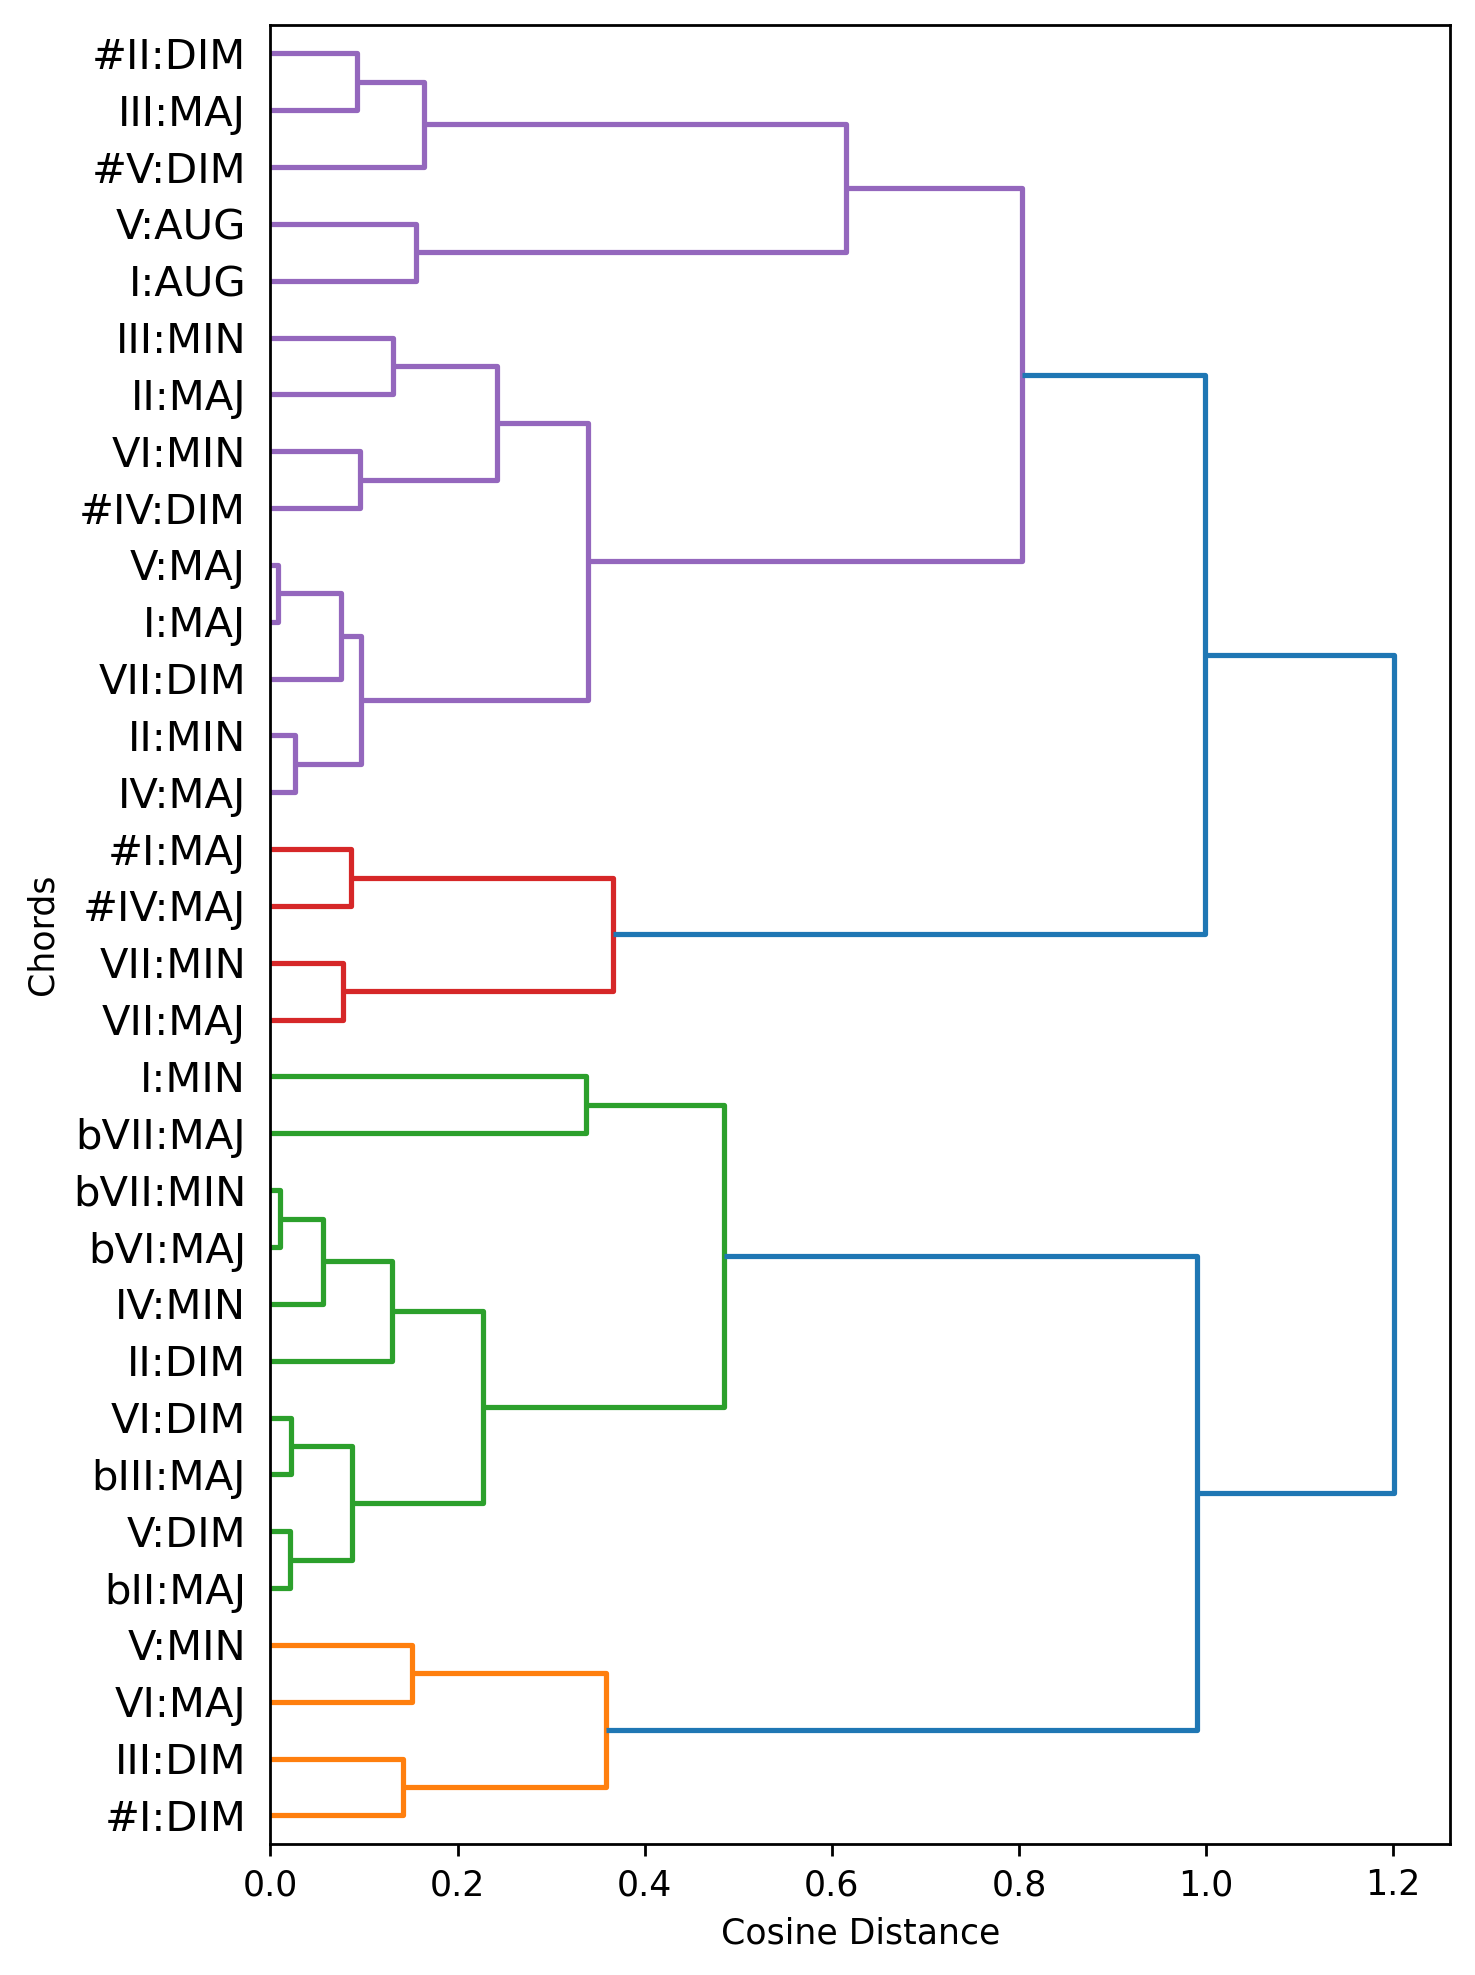

In [14]:
# Only works if agglomerative was constructed with n_clusters=None and distance_threshold=0
plot_dendrogram(agglomerative, leaf_label_func=lambda id : clusters[id][0], orientation='right', dpi=250)

### Reduce dimensionality: PCA / TSNE / Isomap

In [15]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, Isomap
from dimred_cluster import dimred_keyed_vec

In [16]:
n_components = 2

pca = PCA(n_components=n_components)
#tsne = TSNE(n_components=n_components, learning_rate=100, n_iter=50000, n_iter_without_progress=10000)
#isomap = Isomap(n_components=n_components, metric='euclidean')
wv_red = dimred_keyed_vec(w2v_model.wv, pca.fit_transform, comps_to_keep=[0,1])

In [17]:
print(pca.components_[0])
print(pca.components_[1])
print(pca.explained_variance_ratio_)

[-0.69127121  0.16780442 -0.3770657  -0.59144803 -0.04468199]
[ 0.49598052 -0.26115012  0.14781863 -0.76848743  0.27088866]
[0.38565842 0.24857071]


### Visualise
Scatter dimensionality-reduced points.  
The shape of the marker indicates the key mode of the section containing the chord (major/minor/unspecified).  
The colour of the marker indicates the cluster label.

In [18]:
from visual_clusters import visual_chord_vectors_clusters

IndexError: list index out of range

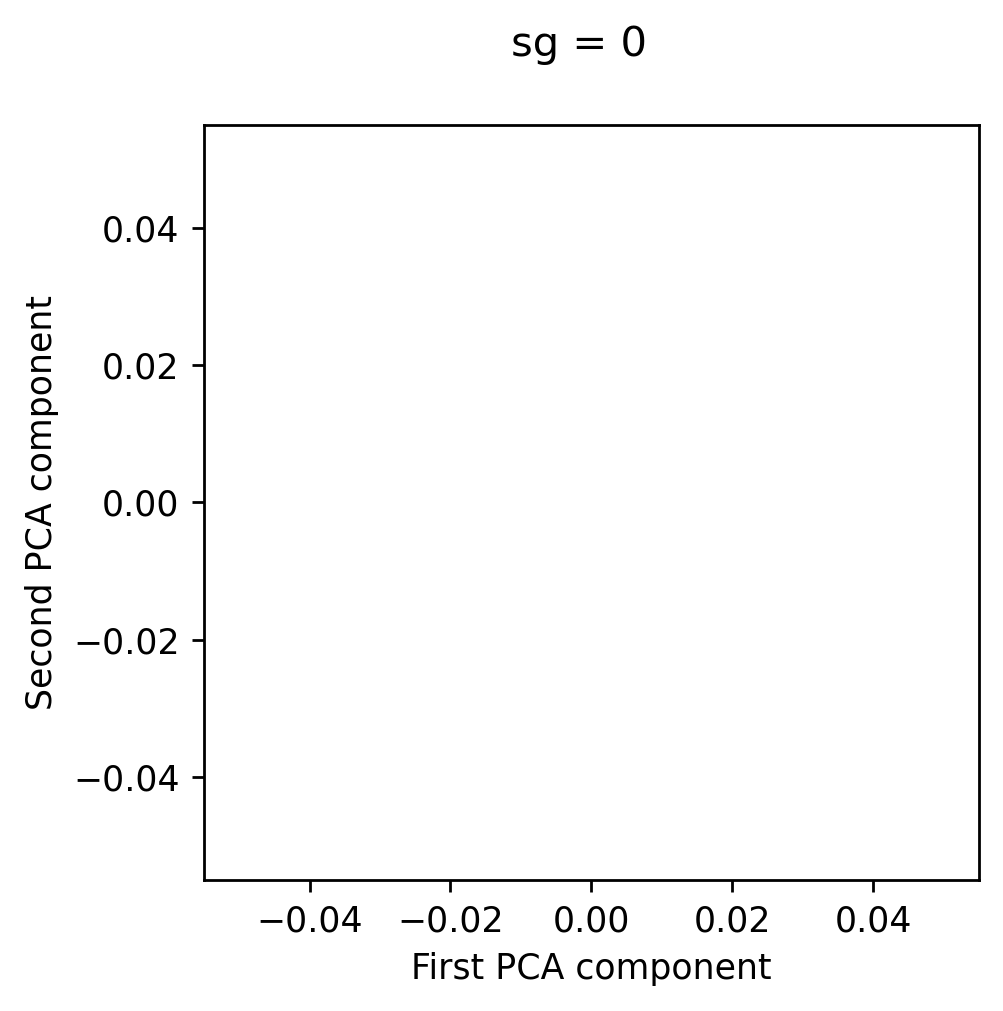

In [19]:
# Only works with <20 clusters (no colours available otherwise)
visual_chord_vectors_clusters(wv_red=wv_red, wv_clus=wv_clus, dimred_method='PCA', 
                             plot_title='sg = 0', 
                             chord_types_to_label=[''], chord_types_not_to_label=[], 
                             marker_size=6, label_size=3, remove_key_mode=False, figsize=(4, 4), dpi=250)

## Investigate similarities

In [ ]:
w2v_model.wv.similarity('I:MIN', 'V:MAJ')

In [ ]:
from visual_clusters import print_similarities

In [ ]:
print_similarities(w2v_model, chord_types_to_print_sim=[''])